In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv("../input/home-data-for-ml-course/train.csv")
train = pd.DataFrame(data)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.drop(['Id'], axis = 1, inplace = True)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

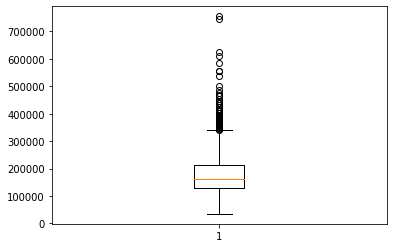

In [4]:
plt.boxplot(train['SalePrice'])
train['SalePrice'].describe()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f04b6a9c8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f04b6a9cf50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f04b6a9c590>],
 'medians': [<matplotlib.lines.Line2D at 0x7f04b6aa35d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f04b6aa38d0>],
 'means': []}

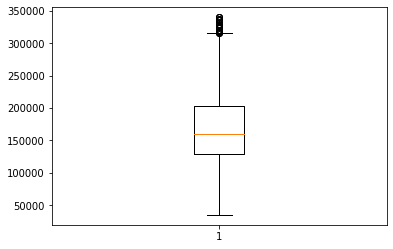

In [5]:
Q1 = np.percentile(train['SalePrice'], 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(train['SalePrice'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
upper = np.where(train['SalePrice'] >= (Q3+1.5*IQR))
lower = np.where(train['SalePrice'] <= (Q1-1.5*IQR))
train.drop(upper[0], inplace = True)
train.drop(lower[0], inplace = True)
plt.boxplot(train['SalePrice'])

In [6]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
for x in train.columns:
    #printing unique values
    print(x ,':', len(train[x].unique()))

MSSubClass : 15
MSZoning : 5
LotFrontage : 108
LotArea : 1017
Street : 2
Alley : 3
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
OverallQual : 10
OverallCond : 9
YearBuilt : 111
YearRemodAdd : 61
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 5
MasVnrArea : 298
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 5
BsmtCond : 5
BsmtExposure : 5
BsmtFinType1 : 7
BsmtFinSF1 : 598
BsmtFinType2 : 7
BsmtFinSF2 : 143
BsmtUnfSF : 751
TotalBsmtSF : 675
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 6
1stFlrSF : 710
2ndFlrSF : 395
LowQualFinSF : 23
GrLivArea : 810
BsmtFullBath : 4
BsmtHalfBath : 3
FullBath : 4
HalfBath : 3
BedroomAbvGr : 8
KitchenAbvGr : 4
KitchenQual : 4
TotRmsAbvGrd : 12
Functional : 7
Fireplaces : 4
FireplaceQu : 6
GarageType : 7
GarageYrBlt : 98
GarageFinish : 4
GarageCars : 5
GarageArea : 411
GarageQual : 6
GarageCond : 6
PavedDrive : 3
Wo

In [8]:
y = train['SalePrice']
train.drop(['SalePrice'], axis = 1, inplace = True)
num_df = train.select_dtypes(include=np.number)
print(num_df.shape)

# Filtering categorical data
cat_df = train.select_dtypes(exclude=np.number)
print(cat_df.shape)

(1399, 36)
(1399, 43)


In [9]:
for x in cat_df.columns:
    #printing unique values
    print(x ,':', len(cat_df[x].unique()))

MSZoning : 5
Street : 2
Alley : 3
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 5
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 5
BsmtCond : 5
BsmtExposure : 5
BsmtFinType1 : 7
BsmtFinType2 : 7
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 6
KitchenQual : 4
Functional : 7
FireplaceQu : 6
GarageType : 7
GarageFinish : 4
GarageQual : 6
GarageCond : 6
PavedDrive : 3
PoolQC : 4
Fence : 5
MiscFeature : 5
SaleType : 9
SaleCondition : 6


In [10]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.NaN, strategy='mean')
num_df = pd.DataFrame(imp_median.fit_transform(num_df), columns=num_df.columns)
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_median = SimpleImputer(missing_values=np.NaN, strategy='constant')
cat_df = pd.DataFrame(imp_median.fit_transform(cat_df), columns=cat_df.columns)
print(cat_df.shape)

cat_df.isnull().sum()
num_df.isnull().sum()

(1399, 36)
(1399, 43)


MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [11]:
cat_df = pd.get_dummies(cat_df)
cat_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_missing_value,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [12]:
cat_df.shape

(1399, 268)

In [13]:
ET = ExtraTreesRegressor()

param_grid = {'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
              'max_depth': range(5, 50, 5),
              'min_samples_leaf': range(1, 11, 2),
              'min_samples_split': range(2, 15, 2),
              'n_estimators': range(50, 300, 50),
              'max_features' : ['sqrt', 'log2', None],
              'bootstrap': ['True', 'False'],
              
             }

ETR = RandomizedSearchCV(estimator = ET,
                            param_distributions = param_grid,
                            scoring = 'neg_mean_absolute_error',
                            n_iter = 200,
                            cv= 3,
                            verbose=1,
                            n_jobs = -1)

ETR.fit(cat_df, y)
print('Best parameters found:\n', ETR.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters found:
 {'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 25, 'criterion': 'absolute_error', 'bootstrap': 'False'}


In [14]:
model = SelectFromModel(ETR.best_estimator_, prefit=True)
feature_idx = model.get_support()
feature_name = cat_df.columns[feature_idx]

cat_new = pd.DataFrame(model.transform(cat_df), columns = feature_name)
cat_new.head()

,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_Reg,LotConfig_Corner,LotConfig_Inside,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,...,FireplaceQu_Gd,FireplaceQu_TA,FireplaceQu_missing_value,GarageType_Attchd,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_TA,SaleCondition_Normal
0,1,0,0,0,1,0,1,1,0,0,...,0,0,1,1,0,0,1,0,1,1
1,1,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,1
2,1,0,1,0,0,0,1,1,0,0,...,0,1,0,1,0,0,1,0,1,1
3,1,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
4,1,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,1


In [15]:
num_new = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(num_df), columns = num_df.columns)
num_new.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.235294,0.150685,0.043768,0.666667,0.500,0.956204,0.883333,0.12250,0.125089,0.0,...,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50
1,0.000000,0.202055,0.050808,0.555556,0.875,0.759124,0.433333,0.00000,0.173281,0.0,...,0.324401,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25
2,0.235294,0.160959,0.060908,0.666667,0.500,0.941606,0.866667,0.10125,0.086109,0.0,...,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50
3,0.294118,0.133562,0.050502,0.666667,0.500,0.313869,0.333333,0.00000,0.038271,0.0,...,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00
4,0.235294,0.215753,0.079334,0.777778,0.500,0.934307,0.833333,0.21875,0.116052,0.0,...,0.589563,0.260870,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50


In [16]:
print(cat_new.shape)
print(num_new.shape)
print(y.shape)

(1399, 54)
(1399, 36)
(1399,)


In [17]:
cat_new.reset_index(drop=True, inplace=True)
num_new.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace = True)

# Concatinating numerical and categorical data
train_pre = pd.concat([cat_new, num_new, y], axis=1)
Rtrain = pd.DataFrame(train_pre)

# Verifying missing values
print(f'Total missing values: {Rtrain.isnull().sum().sum()}')
print(Rtrain.shape)
Rtrain.head()

Total missing values: 0
(1399, 91)


,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_Reg,LotConfig_Corner,LotConfig_Inside,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,0,0,0,1,0,1,1,0,0,...,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,208500
1,1,0,0,0,1,0,0,0,0,0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,181500
2,1,0,1,0,0,0,1,1,0,0,...,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,223500
3,1,0,1,0,0,1,0,0,1,0,...,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00,140000
4,1,0,1,0,0,0,0,0,0,0,...,0.260870,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,250000


In [18]:
y= Rtrain['SalePrice']
X = Rtrain.drop(['SalePrice'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [19]:
warnings.simplefilter("ignore")

lg = lgb.LGBMRegressor(objective = 'mae')

lgb_parameters = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': range(2, 21, 2),
    'max_depth': [20, 301, 10],
    'learning_rate' : [x / 100.0 for x in range(10, 100, 5)],
    'n_estimators': range(50, 501, 50)
}


lgb_grid = RandomizedSearchCV(estimator = lg,
                            param_distributions = lgb_parameters,
                            scoring = 'neg_mean_absolute_error',
                            n_iter = 500,
                            cv= 3,
                            verbose=1,
                            n_jobs = -1)

lgb_grid.fit(X_train, y_train)
print('Best parameters found:\n', lgb_grid.best_params_)
print('Best MAE Score: ',lgb_grid.best_score_ )

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Best parameters found:
 {'num_leaves': 10, 'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Best MAE Score:  -14303.379696011345


In [20]:
best_params = lgb_grid.best_estimator_
y_hat = best_params.predict(X_test)
LGB_MAE = metrics.mean_absolute_error(y_hat, y_test)

print('LGB MAE: ', LGB_MAE)

LGB MAE:  13200.33843154268


LGB MAE with 0.9 dropping columns and imputing categorical data as MODE and numerical data as MEDIAN is **1**


LGB MAE with no dropping columns and imputing categorical data as CONSTANT and numerical data as MEDIAN is **1**

LGB MAE with no dropping columns and imputing categorical data as CONSTANT and numerical data as MEAN is **13631**

LGB MAE with no dropping columns and imputing categorical data as CONSTANT and numerical data as MEAN is **13354**

In [24]:
import xgboost

xgb = xgboost.XGBRegressor()

xgb_parameters = {
    'objective': ['reg:absoluteerror', 'reg:squarederror', 'reg:pseudohubererror'],
    'learning_rate': [x / 100.0 for x in range(10, 100, 5)],
    'max_depth': range (2, 13, 2),
    'min_child_weight': range(2, 20, 2),
    'subsample': [x / 100.0 for x in range(10, 100, 5)],
    'colsample_bytree': [x / 100.0 for x in range(10, 100, 5)],
    'n_estimators': range(50, 1000, 50),
    'gamma':[x / 100.0 for x in range(10, 100, 5)]
}


xgb_grid = RandomizedSearchCV(estimator = xgb,
                            param_distributions = xgb_parameters,
                            scoring = 'neg_mean_absolute_error',
                            n_iter = 500,
                            cv= 3,
                            verbose=1,
                            n_jobs = -1)

xgb_grid.fit(X_train, y_train)
print('Best parameters found:\n', xgb_grid.best_params_)
print('Best MAE Score: ',xgb_grid.best_score_ )

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Best parameters found:
 {'subsample': 0.65, 'objective': 'reg:squarederror', 'n_estimators': 900, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.35, 'colsample_bytree': 0.25}
Best MAE Score:  -14392.754405502868


In [25]:
best_params = xgb_grid.best_estimator_
y_hat = best_params.predict(X_test)
XGB_MAE = metrics.mean_absolute_error(y_hat, y_test)

print('XGB MAE: ', XGB_MAE)

XGB MAE:  13485.332370721726


1st try = 13864

In [38]:
data = pd.read_csv("../input/home-data-for-ml-course/train.csv")
train = pd.DataFrame(data)

y = train['SalePrice']
X = train.drop(['Id', 'SalePrice'], axis = 1)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

num_pre = Pipeline(steps = 
                   [('Num Imputer', SimpleImputer(missing_values = np.NaN, strategy = 'mean')),
                    ('Scaler', preprocessing.MinMaxScaler())])

cat_pre = Pipeline(steps = 
                  [('Cat Imputer', SimpleImputer(missing_values = np.NaN, strategy = 'constant')),
                   ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
                   ('Cat Selector', SelectFromModel(ExtraTreesRegressor(**ETR.best_params_)))
                  ])

preprocessor = ColumnTransformer(transformers = [
    ('Num Transformer', num_pre, selector(dtype_include=np.number)),
    ('Cat Transformer', cat_pre, selector(dtype_exclude=np.number))
])

pipe = Pipeline(steps = 
               [('preprocessor', preprocessor),
                ('LGBMRegressor', lgb.LGBMRegressor(**lgb_grid.best_params_))
               ])

pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Num Transformer',
                                                  Pipeline(steps=[('Num '
                                                                   'Imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0496203310>),
                                                 ('Cat Transformer',
                                                  Pipeline(steps=[('Cat '
                                                                   'Imputer',
                                                                   SimpleImputer(strategy='constant')),
                                     

In [40]:
data = pd.read_csv("../input/home-data-for-ml-course/test.csv")
test = pd.DataFrame(data)

TestID = test['Id']
test.drop(['Id'], axis = 1, inplace = True)
test.head()

TestID.shape

(1459,)

In [41]:
y_pred = pipe.predict(test)

result = pd.DataFrame(y_pred, columns = ['SalePrice'])

#TID = pd.DataFrame(TestID)
sub = pd.concat([TestID, result], axis =1)
sub.head()

,Id,SalePrice
0,1461,123542.168542
1,1462,162785.551473
2,1463,187000.551651
3,1464,193702.920480
4,1465,185864.515790


In [42]:
sub.to_csv("sub.csv", index=False)

In [ ]:
sub.shape

In [ ]:
sub.head()